# BananaCNN

> Development of a BANANA Image Classifier using CNN

## Revision History

- yyyy/mm/dd Activity

## Step 1. Install Dependencies

> Install the required third-party libraries.

In [1]:
%pip install -U jupyterlab
%pip install -U notebook
%pip install -U pandas
%pip install -U opencv-python 
%pip install -U scikit-learn
%pip install -U scikit-image
%pip install -U matplotlib
%pip install -U pillow
%pip install -U seaborn
%pip install -U tensorflow
print("Environment is ready...")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl (376.0 MB)
Note: you may need to restart the kernel to use updated packages.
Environment is ready...


## Step 2: Import the Packages

> Import all third-party libraries necessary for the CNN model to execute successfully.

In [2]:
import os

os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import glob
import json
import time
import warnings
from datetime import datetime

warnings.filterwarnings("ignore", category=RuntimeWarning, message="os.fork()")
warnings.filterwarnings("ignore", category=UserWarning, message="Your `PyDataset` class should call")

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
)
from tensorflow.keras.optimizers import Adadelta

gpus = tf.config.list_physical_devices("GPU")

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
            print(e)
    print("GPU detected. Running on GPU.")
else:
    print("No GPU detected. Running on CPU.")

No GPU detected. Running on CPU.


## Step 3: Load Datasets

> Load and prepare the training, validation, and testing datasets.

In [3]:
DATA_DIR = "data"
IMAGE_SIZE = 224
IMAGE_CHANNELS = 3

BATCH_SIZE = 8

all_images = glob.glob(f"{DATA_DIR}/*/*.jpg")
df = pd.DataFrame({
    "filepath": all_images,
    "label": [os.path.basename(os.path.dirname(p)) for p in all_images]
})

train_val_df, test_df = train_test_split(df, test_size=0.1, stratify=df["label"], shuffle=True)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df["label"], shuffle=True)

generator1 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_data = generator1.flow_from_dataframe(
    train_df, x_col="filepath", y_col="label", target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, class_mode="categorical", shuffle=True
)

NUM_CLASSES = max(train_data.classes) + 1

generator2 = ImageDataGenerator(rescale=1./255)

val_data = generator2.flow_from_dataframe(
    val_df, x_col="filepath", y_col="label", target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, class_mode="categorical", shuffle=True
)

test_data = generator2.flow_from_dataframe(
    test_df, x_col="filepath", y_col="label", target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, class_mode="categorical", shuffle=False
)

Found 216 validated image filenames belonging to 3 classes.
Found 54 validated image filenames belonging to 3 classes.
Found 30 validated image filenames belonging to 3 classes.


## Step 4: Define the Architecture

> Define the structure of the CNN for BANANA classification.

In [4]:
model = Sequential()

model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)))

model.add(Conv2D(32, (3, 3), activation="swish", padding="same"))
model.add(Conv2D(32, (3, 3), activation="swish", padding="same"))
model.add(Conv2D(32, (3, 3), activation="swish", padding="same"))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation="swish", padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(32, activation="swish"))
model.add(Dense(32, activation="swish"))
model.add(Dropout(0.1))

model.add(Dense(NUM_CLASSES, activation="softmax"))

optimizer = Adadelta(learning_rate=1.0, rho=0.95)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape         ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ conv2d (Conv2D)             │ (None, 224, 224, 32) │         896 │
├─────────────────────────────┼──────────────────────┼─────────────┤
│ conv2d_1 (Conv2D)           │ (None, 224, 224, 32) │       9,248 │
├─────────────────────────────┼──────────────────────┼─────────────┤
│ conv2d_2 (Conv2D)           │ (None, 224, 224, 32) │       9,248 │
├─────────────────────────────┼──────────────────────┼─────────────┤
│ max_pooling2d               │ (None, 112, 112, 32) │           0 │
│ (MaxPooling2D)              │                      │             │
├─────────────────────────────┼──────────────────────┼─────────────┤
│ conv2d_3 (Conv2D)           │ (None, 112, 112, 64) │      18,496 │
├─────────────────────────────┼──────────────────────┼─────────────┤
│ max_pooling2d_1             │ (None, 56, 56, 64)   │           0 │
│ (MaxPooling2D)              │                      │             │
├─────────────────────────────┼──────────────────────┼─────────────┤
│ dropout (Dropout)           │ (None, 56, 56, 64)   │           0 │
├─────────────────────────────┼──────────────────────┼─────────────┤
│ flatten (Flatten)           │ (None, 200704)       │           0 │
├─────────────────────────────┼──────────────────────┼─────────────┤
│ dense (Dense)               │ (None, 32)           │   6,422,560 │
├─────────────────────────────┼──────────────────────┼─────────────┤
│ dense_1 (Dense)             │ (None, 32)           │       1,056 │
├─────────────────────────────┼──────────────────────┼─────────────┤
│ dropout_1 (Dropout)         │ (None, 32)           │           0 │
├─────────────────────────────┼──────────────────────┼─────────────┤
│ dense_2 (Dense)             │ (None, 3)            │          99 │
└─────────────────────────────┴──────────────────────┴─────────────┘

 Total params: 6,461,603 (24.65 MB)

 Trainable params: 6,461,603 (24.65 MB)

 Non-trainable params: 0 (0.00 B)

## Step 5: Train the Model 

> Feed the training-val dataset to the compiled CNN model.

In [5]:
EPOCHS = 100
MODELS = "models"
ANALYSIS = "analysis"
ARCHITECTURE = "CNN"

os.makedirs(MODELS, exist_ok=True)
os.makedirs(ANALYSIS, exist_ok=True)

training_timestamp = int(time.time())

history = model.fit(train_data, validation_data=val_data, epochs=EPOCHS)

training_duration = (int(time.time()) - training_timestamp) / 60

fullpath = f"{MODELS}/topic.{ARCHITECTURE}_{training_timestamp}.keras"
model.save(fullpath)

with open(f"{ANALYSIS}/metrics_{training_timestamp}.json", "w") as f:
    json.dump({
        "loss": history.history["loss"],
        "accuracy": history.history["accuracy"],
        "val_loss": history.history["val_loss"],
        "val_accuracy": history.history["val_accuracy"]
    }, f, indent=4)

print(f"Training completed in {training_duration:.2f} minutes.")
print(f"Metrics saved to '{ANALYSIS}/metrics_{training_timestamp}.json'")
print(f"Model saved to '{fullpath}'")

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - accuracy: 0.4055 - loss: 1.1088 - val_accuracy: 0.3333 - val_loss: 0.9764
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.4366 - loss: 1.1067 - val_accuracy: 0.3333 - val_loss: 1.0272
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.5556 - loss: 0.8803 - val_accuracy: 0.8519 - val_loss: 0.5983
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.6247 - loss: 0.7652 - val_accuracy: 0.6667 - val_loss: 0.5128
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.6598 - loss: 0.5816 - val_accuracy: 0.8889 - val_loss: 0.3861
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.7448 - loss: 0.5725 - val_accuracy: 0.6667 - val_loss: 0.4290
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.7604 - loss: 0.5654 - val_accuracy: 0.7407 - val_loss: 0.3959
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.7609 - loss: 0.3968 - val_accuracy: 0.9259 - 

## Step 6: Generate Training Analysis 

**Metrics Definitions** 

- Loss is computed based on how far each prediction is from the ground truth, 
specifically using Categorical Cross-entropy.
- Accuracy is the proportion of correct predictions to the total predictions.

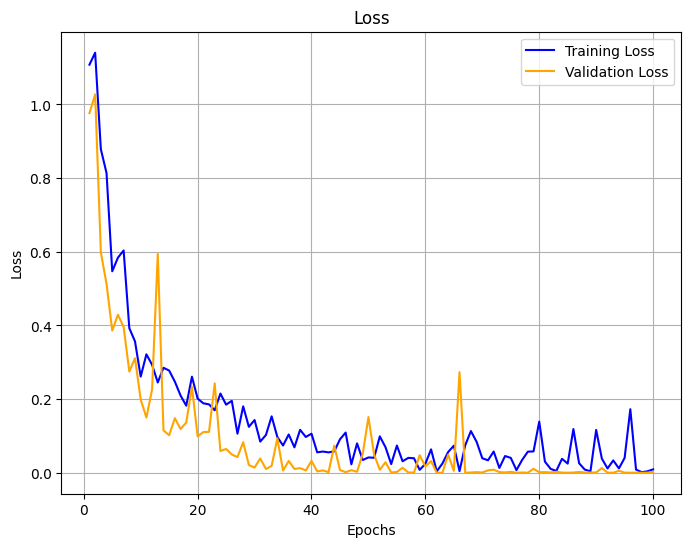

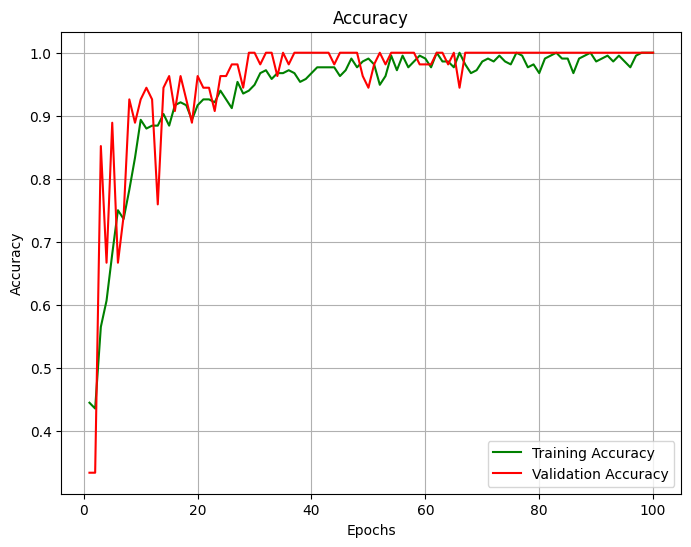


Plots saved to analysis


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

with open(f"{ANALYSIS}/metrics_{training_timestamp}.json", "r") as f:
    metrics = json.load(f)

epochs = [i for i in range(1, len(metrics["loss"])+1)]

plt.figure(figsize=(8, 6))
sns.lineplot(x=epochs, y=metrics["loss"], label="Training Loss", color="blue")
sns.lineplot(x=epochs, y=metrics["val_loss"], label="Validation Loss", color="orange")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig(f"{ANALYSIS}/loss_plot_{training_timestamp}.png")
plt.show()

plt.figure(figsize=(8, 6))
sns.lineplot(x=epochs, y=metrics["accuracy"], label="Training Accuracy", color="green")
sns.lineplot(x=epochs, y=metrics["val_accuracy"], label="Validation Accuracy", color="red")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.savefig(f"{ANALYSIS}/accuracy_plot_{training_timestamp}.png")
plt.show()

print(f"\nPlots saved to {ANALYSIS}")

## Step 7: Test the Model

> Run the model using the test dataset.

In [7]:
start_time = time.time()
results = model.predict(test_data, verbose=1)
prediction_duration = time.time() - start_time
image_prediction_time = prediction_duration / test_data.samples

predictions = (results > 0.5).astype("int32").flatten() if results.shape[1] == 1 else results.argmax(axis=1)

print(f"Total prediction time: {prediction_duration:.4f} seconds")
print(f"Time per image: {image_prediction_time:.4f} seconds")

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Total prediction time: 7.9852 seconds
Time per image: 0.2662 seconds


## Step 8: Display the Results

> Show the actual classes and predictions.

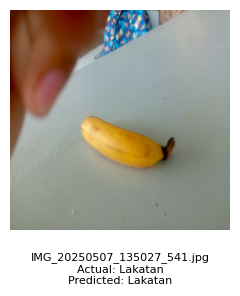

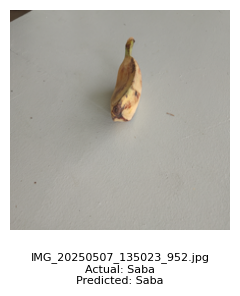

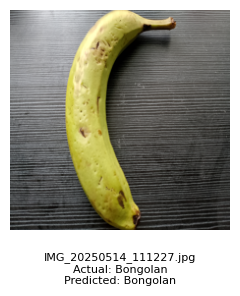

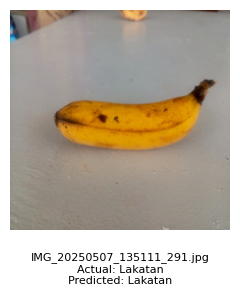

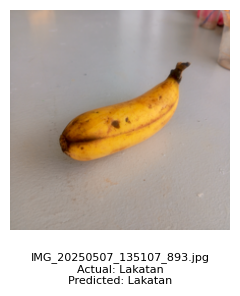

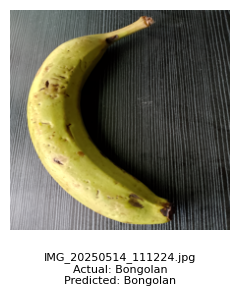

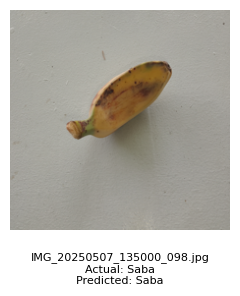

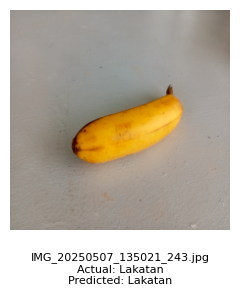

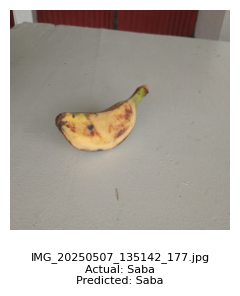

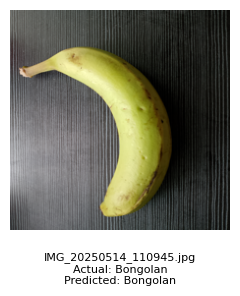

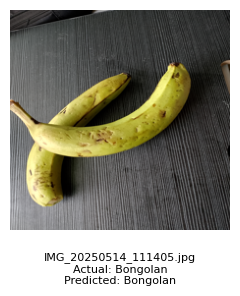

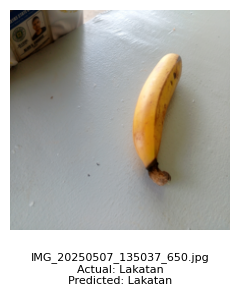

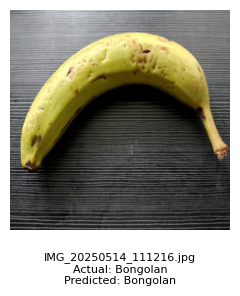

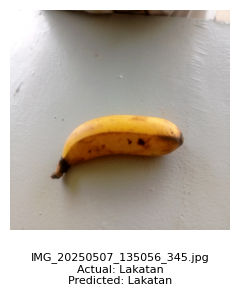

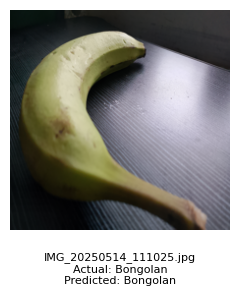

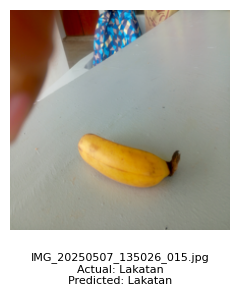

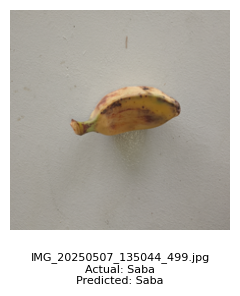

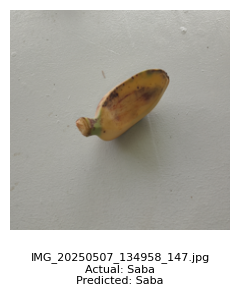

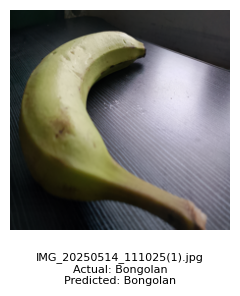

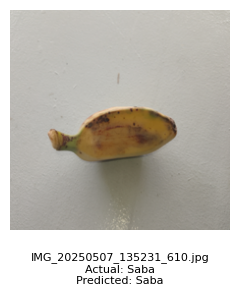

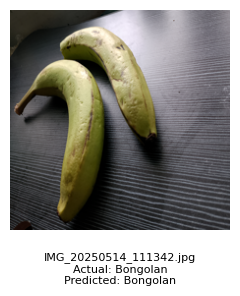

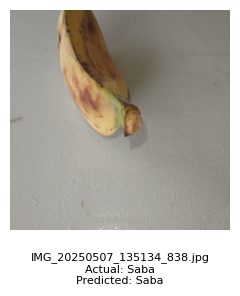

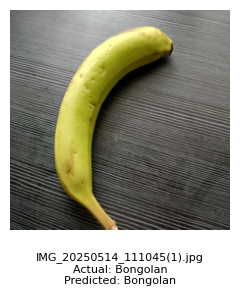

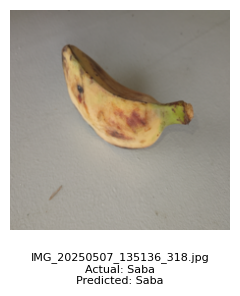

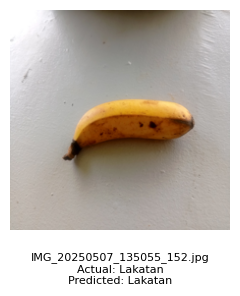

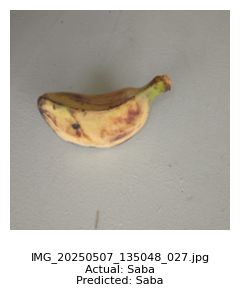

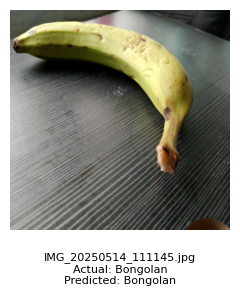

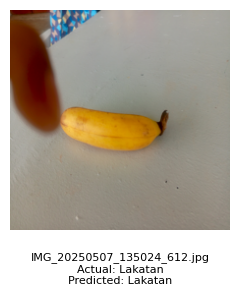

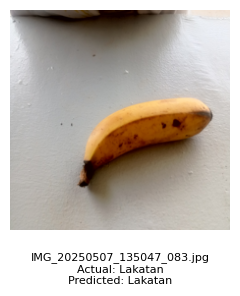

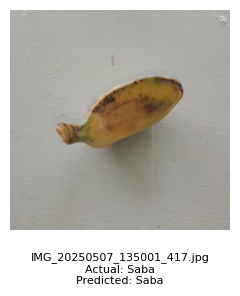

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os

# Get the file paths from the test_df DataFrame
filepaths = test_df["filepath"].tolist()

# Get the true indices from the test data generator
true_indices = test_data.classes

# Get the class labels mapping
labels = list(test_data.class_indices.keys())

# Ensure the number of filepaths, true indices, and predictions match
if len(filepaths) != len(true_indices) or len(filepaths) != len(predictions):
    print("Warning: Mismatch in the number of file paths, true labels, and predictions.")
    # You might want to handle this mismatch depending on the root cause

for fp, true, pred in zip(filepaths, true_indices, predictions):
    img = Image.open(fp).resize((224, 224))

    filename = os.path.basename(fp)
    actual = labels[true].replace("-", " ").title()
    predicted = labels[pred].replace("-", " ").title()

    plt.figure(figsize=(2.5, 3))
    plt.imshow(img)
    plt.axis('off')

    text = f"{filename}\nActual: {actual}\nPredicted: {predicted}"
    plt.text(0.5, -0.1, text, fontsize=8, ha="center", va="top", transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

## Step 9: Confusion Matrix with Cohen's Kappa Score Analysis

> The ideal matrix is a left-to-right diagonal; however, the Cohen's Kappa score is 
calculated to quantify the results.

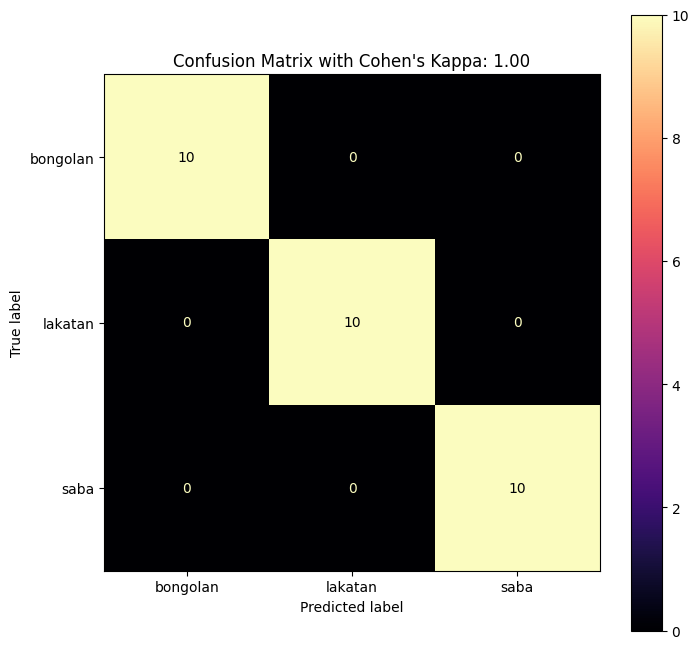

Interpretation of Kappa Score: Almost perfect agreement


In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score

true_indices = test_data.classes
class_labels = list(test_data.class_indices.keys())

cm = confusion_matrix(true_indices, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
kappa_score = cohen_kappa_score(true_indices, predictions)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap="magma", ax=ax)
plt.title(f"Confusion Matrix with Cohen's Kappa: {kappa_score:.2f}")
plt.savefig(f"{ANALYSIS}/confusion-matrix_{training_timestamp}.png")
plt.show()

# Landis & Koch (1977) scale
kappa_scale = {
    (-1.0, 0.00): "Poor agreement",
    (0.00, 0.20): "Slight agreement",
    (0.21, 0.40): "Fair agreement",
    (0.41, 0.60): "Moderate agreement",
    (0.61, 0.80): "Substantial agreement",
    (0.81, 1.00): "Almost perfect agreement"
}

for interval, label in kappa_scale.items():
    if interval[0] < kappa_score <= interval[1]:
        print(f"Interpretation of Kappa Score: {label}")
        break

---
End code.